In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict
from sklearn.tree import export_text
from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [70]:
logon_data = pd.read_csv('data/logon.csv')
device_data = pd.read_csv('data/device.csv')
http_data = pd.read_csv('data/http_2.csv')

In [71]:
len(logon_data)
#logon_data.head()

867070

In [72]:
len(device_data)
#device_data.head()

825496

In [73]:
http_data.head()

id                 date     user       pc  \
0  {U0G4-P5TW04EO-9366IUQF}  01/02/2010 06:36:20  EBH0519  PC-9573   
1  {G0R5-U4RX40DR-3710WPUY}  01/02/2010 06:39:22  EBH0519  PC-9573   
2  {G0Q6-F5CV96RX-0355APNP}  01/02/2010 06:39:53  EBH0519  PC-9573   
3  {J8X0-C9ZO08VS-9370QIFO}  01/02/2010 06:40:56  EBH0519  PC-9573   
4  {E0J4-D6WM72LS-9186JPKE}  01/02/2010 06:47:23  EBH0519  PC-9573   

                                                 url  \
0  http://usbank.com/1930_FIFA_World_Cup/patenaud...   
1          http://forbes.com/Chorioactis/urnula.html   
2  http://coupons.com/BeauchampSharp_Tragedy/darb...   
3     http://youtube.com/Amanita_ocreata/velosa.html   
4                http://twitter.com/Cannon/m198.html   

                                             content  
0  neros printing pastiche four topiary body pink...  
1  balhae fubing guotu namsaeng geng chuzhou ying...  
2  ziyi hazelnuts 34850 stat_area1 namsaeng kucha...  
3  flambard anselm anselm precentor thurgot visit...  
4  maternus henrici anselm walkelin maternus thur...

In [74]:
logon_data['user'].value_counts().head(10)

user
JVS0212    4966
ZNS0213    4852
HKW0211    4676
DWG0209    4620
BLA0039    4564
LUP0038    4560
UAP0214    4474
PAW0040    4302
WSP0210    1995
ABG0865    1680
Name: count, dtype: int64

In [75]:
logon_data.shape

(867070, 5)

In [76]:
logon_data['date'] = pd.to_datetime(logon_data['date'])
logon_data['day'] = logon_data['date'].dt.dayofweek
logon_data['hour'] = logon_data['date'].dt.hour

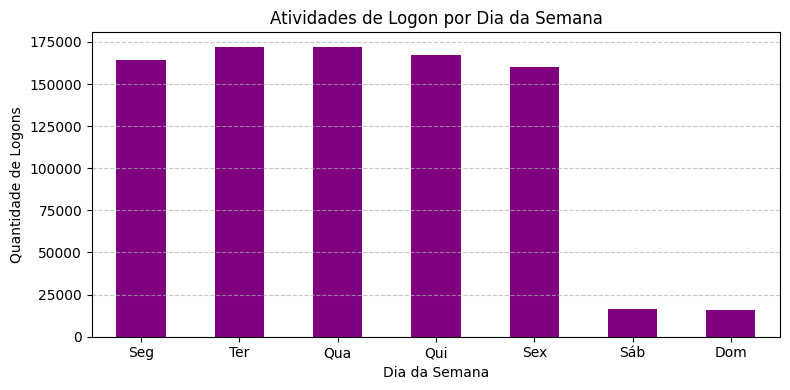

In [77]:
#GRAFICO ATIVIDADES LOGON DIAS DAS SEMANA

# Mapeamento dos dias da semana
dias_semana = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'S√°b', 'Dom']

# Contagem ordenada por √≠ndice do dia
contagem_dias = logon_data['day'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 4))
contagem_dias.plot(kind='bar', color='purple')
plt.title('Atividades de Logon por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade de Logons')
plt.xticks(ticks=range(7), labels=dias_semana, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.savefig("imagens/grafico-atividade-de-logon-semana.png", dpi=300)
plt.show()


In [78]:
# Agrega√ß√µes principais por usu√°rio

logon_features = logon_data.groupby('user').agg(
    computadores_distintos=('pc', 'nunique'),

    total_logons=('activity', lambda x: (x == 'Logon').sum()),
    total_logoffs=('activity', lambda x: (x == 'Logoff').sum()),

    computador_mais_usado=('pc', lambda x: x.value_counts().idxmax()),

    hora_logon_mais_comum=('hour', lambda x: x[logon_data.loc[x.index, 'activity'] == 'Logon'].mode()[0]
                           if not x[logon_data.loc[x.index, 'activity'] == 'Logon'].empty else -1),

    hora_logoff_mais_comum=('hour', lambda x: x[logon_data.loc[x.index, 'activity'] == 'Logoff'].mode()[0]
                            if not x[logon_data.loc[x.index, 'activity'] == 'Logoff'].empty else -1),

    # Logons no fim de semana (s√°bado=5 ou domingo=6)
    logons_fim_de_semana=('day', lambda x: ((logon_data.loc[x.index, 'activity'] == 'Logon') &
                                            (x.isin([5, 6]))).sum()),

    # Logons em dias √∫teis (segunda=0 a sexta=4)
    logons_dias_uteis=('day', lambda x: ((logon_data.loc[x.index, 'activity'] == 'Logon') &
                                         (x.isin([0, 1, 2, 3, 4]))).sum()),

    # Logons fora do hor√°rio comercial (antes de 7h ou ap√≥s 18h) apenas em dias √∫teis
    logons_fora_horario_comercial=('hour', lambda x: ((logon_data.loc[x.index, 'activity'] == 'Logon') &
                                                  (logon_data.loc[x.index, 'day'].isin([0, 1, 2, 3, 4])) &
                                                  ((x < 7) | (x > 18))).sum()),

    # Logons dentro do hor√°rio comercial (7h √†s 18h) apenas em dias √∫teis
    logons_em_horario_comercial=('hour', lambda x: ((logon_data.loc[x.index, 'activity'] == 'Logon') &
                                                    (logon_data.loc[x.index, 'day'].isin([0, 1, 2, 3, 4])) &
                                                    ((x >= 7) & (x <= 18))).sum()),

    # Logons fora do hor√°rio comercial com janela de acesso (antes de 22h e ap√≥s 18h) apenas em dias √∫teis
    logons_janela_acesso=('hour', lambda x: ((logon_data.loc[x.index, 'activity'] == 'Logon') &
                                                  (logon_data.loc[x.index, 'day'].isin([0, 1, 2, 3, 4])) &
                                                  ((x < 22) & (x > 18))).sum()),

    proporcao_pc_mais_usado=('pc', lambda x: (x.value_counts().max() / len(x)))
).reset_index()

In [79]:
logon_features

user  computadores_distintos  total_logons  total_logoffs  \
0     AAB0754                       1            17              9   
1     AAC0070                       1           345            345   
2     AAN0077                       1            10             10   
3     AAP0946                       2           727            458   
4     AAR0716                       2           631            362   
...       ...                     ...           ...            ...   
1995  ZNF0145                       2            22             15   
1996  ZNS0213                     792          2562           2290   
1997  ZSP0972                       1           345            345   
1998  ZWF0919                       1            17             10   
1999  ZXA0931                       2            24             16   

     computador_mais_usado  hora_logon_mais_comum  hora_logoff_mais_comum  \
0                  PC-5948                      9                      19   
1                  PC-9582                      7                      18   
2                  PC-9130                      8                      16   
3                  PC-6599                      8                      18   
4                  PC-8861                      7                      15   
...                    ...                    ...                     ...   
1995               PC-1673                      8                      17   
1996               PC-3066                      7                      15   
1997               PC-5819                      9                      17   
1998               PC-0742                      7                      17   
1999               PC-2567                      7                      17   

      logons_fim_de_semana  logons_dias_uteis  logons_fora_horario_comercial  \
0                        0                 17                              0   
1                        0                345                              0   
2                        0                 10                              0   
3                        0                727                              0   
4                        0                631                            171   
...                    ...                ...                            ...   
1995                     3                 19                              0   
1996                     0               2562                           1438   
1997                     0                345                              0   
1998                     0                 17                              0   
1999                     0                 24                              3   

      logons_em_horario_comercial  logons_janela_acesso  \
0                              17                     0   
1                             345                     0   
2                              10                     0   
3                             727                     0   
4                             460                     0   
...                           ...                   ...   
1995                           19                     0   
1996                         1124                   409   
1997                          345                     0   
1998                           17                     0   
1999                           21                     0   

      proporcao_pc_mais_usado  
0                    1.000000  
1                    1.000000  
2                    1.000000  
3                    0.809283  
4                    0.965760  
...                       ...  
1995                 0.837838  
1996                 0.198269  
1997                 1.000000  
1998                 1.000000  
1999                 0.850000  

[2000 rows x 13 columns]

In [80]:
device_data['date'] = pd.to_datetime(device_data['date'])
device_data['day'] = device_data['date'].dt.dayofweek
device_data['hour'] = device_data['date'].dt.hour

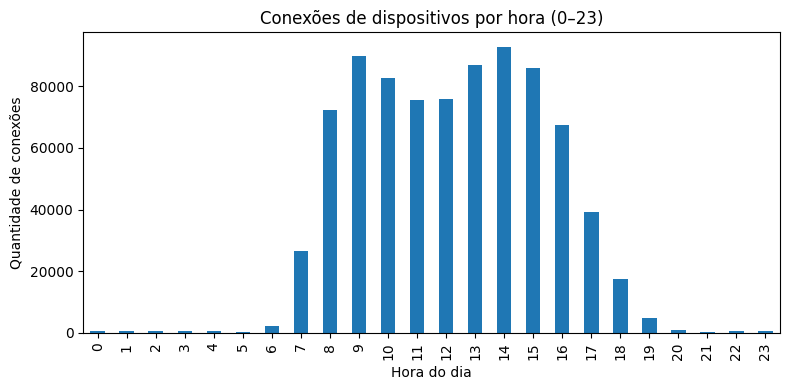

In [81]:
#CONEXOES DE USER

device_features = device_data.groupby('user').agg(

    pcs_distintos_dispositivo=('pc', 'nunique'),
    total_atividades_dispositivo=('activity', 'count'),

    # Conex√µes fora do hor√°rio comercial (dias √∫teis antes das 07h ou ap√≥s as 18h)
    connect_fora_horario_comercial=('activity', lambda a: (
        ((a.str.contains('connect', case=False, na=False)) &
         (device_data.loc[a.index, 'day'].isin([0, 1, 2, 3, 4])) &
         ((device_data.loc[a.index, 'hour'] < 7) | (device_data.loc[a.index, 'hour'] > 18)))
    ).sum()),

    # Conex√µes dentro do hor√°rio comercial (dias √∫teis das 07h √†s 18h)
    connect_em_horario_comercial=('activity', lambda a: (
        ((a.str.contains('connect', case=False, na=False)) &
         (device_data.loc[a.index, 'day'].isin([0, 1, 2, 3, 4])) &
         ((device_data.loc[a.index, 'hour'] >= 7) & (device_data.loc[a.index, 'hour'] <= 18)))
    ).sum()),

    # Conex√µes fim de semana
    connect_fim_de_semana=('activity', lambda a: (
        a.str.contains('connect', case=False, na=False) &
        device_data.loc[a.index, 'day'].isin([5, 6])
    ).sum()),

    # Conex√µes dias √∫teis
    connect_dias_uteis=('activity', lambda a: (
        a.str.contains('connect', case=False, na=False) &
        device_data.loc[a.index, 'day'].isin([0, 1, 2, 3, 4])
    ).sum()),

    # Conex√µes na "janela de acesso" (dias √∫teis, entre 18h e 22h)
    connect_janela_acesso=('activity', lambda a: (
        a.str.contains('connect', case=False, na=False) &
        device_data.loc[a.index, 'day'].isin([0, 1, 2, 3, 4]) &
        (device_data.loc[a.index, 'hour'] > 18) &
        (device_data.loc[a.index, 'hour'] < 22)
    ).sum()),

    # Total de conex√µes
    total_connect_dispositivo=('activity', lambda a: a.str.contains('connect', case=False, na=False).sum()),

    # Total de desconex√µes
    total_disconnect_dispositivo=('activity', lambda a: a.str.contains('disconnect', case=False, na=False).sum()),

    # Diferen√ßa entre conex√µes e desconex√µes
    conexoes_sem_desconexao=('activity', lambda a: (
        a.str.contains('connect', case=False, na=False).sum() -
        a.str.contains('disconnect', case=False, na=False).sum()
    ))
    

).reset_index()

# S√©rie de conex√µes por hora (todas as conex√µes 'connect')
is_connect = device_data['activity'].str.contains('connect', case=False, na=False)
counts_by_hour = (device_data.loc[is_connect]
                  .groupby(device_data.loc[is_connect, 'hour'])
                  .size().reindex(range(24), fill_value=0))

plt.figure(figsize=(8,4))
counts_by_hour.plot(kind='bar')
plt.title('Conex√µes de dispositivos por hora (0‚Äì23)')
plt.xlabel('Hora do dia')
plt.ylabel('Quantidade de conex√µes')
plt.tight_layout()
#plt.savefig("imagens/grafico-conexoes-de-dispositivo.png", dpi=300)
plt.show()




In [82]:
device_features

user  pcs_distintos_dispositivo  total_atividades_dispositivo  \
0    AAS0850                          1                           686   
1    ABH0821                          1                           310   
2    ABM0513                          1                          2095   
3    ABW0673                          1                          1964   
4    ACR0100                          1                           219   
..       ...                        ...                           ...   
432  ZED0676                          1                           675   
433  ZNF0145                          1                          1618   
434  ZNS0213                          1                           670   
435  ZWF0919                          1                          1280   
436  ZXA0931                          1                           732   

     connect_fora_horario_comercial  connect_em_horario_comercial  \
0                                 0                           686   
1                                 4                           244   
2                                 0                          2095   
3                                 0                          1386   
4                                 0                           219   
..                              ...                           ...   
432                               0                           675   
433                               0                          1381   
434                               0                           670   
435                               0                          1280   
436                              11                           719   

     connect_fim_de_semana  connect_dias_uteis  connect_janela_acesso  \
0                        0                 686                      0   
1                       62                 248                      0   
2                        0                2095                      0   
3                      578                1386                      0   
4                        0                 219                      0   
..                     ...                 ...                    ...   
432                      0                 675                      0   
433                    237                1381                      0   
434                      0                 670                      0   
435                      0                1280                      0   
436                      2                 730                      1   

     total_connect_dispositivo  total_disconnect_dispositivo  \
0                          686                           329   
1                          310                           148   
2                         2095                          1034   
3                         1964                           959   
4                          219                           102   
..                         ...                           ...   
432                        675                           326   
433                       1618                           791   
434                        670                           323   
435                       1280                           623   
436                        732                           353   

     conexoes_sem_desconexao  
0                        357  
1                        162  
2                       1061  
3                       1005  
4                        117  
..                       ...  
432                      349  
433                      827  
434                      347  
435                      657  
436                      379  

[437 rows x 11 columns]

In [83]:
http_data['date'] = pd.to_datetime(http_data['date'])
http_data['day'] = http_data['date'].dt.dayofweek
http_data['hour'] = http_data['date'].dt.hour

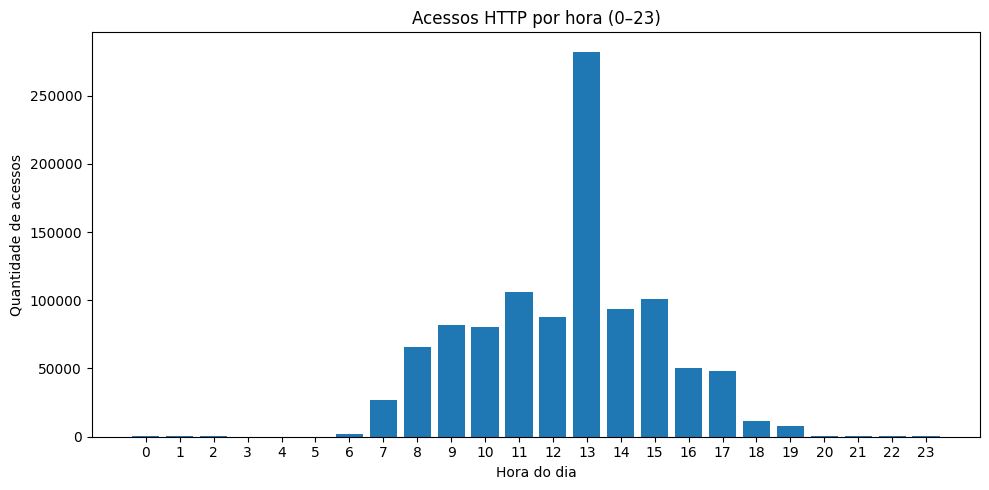

In [84]:
#CONTROLE DE ACESSO

http_features = http_data.groupby('user').agg(

    # Quantidade de sites √∫nicos visitados
    sites_distintos_visitados=('url', 'nunique'),

    # Total de acessos HTTP (linhas registradas)
    total_acessos_http=('url', 'count'),

    # Acessos fora do hor√°rio comercial (dias √∫teis antes das 07h ou ap√≥s as 18h)
    acessos_fora_horario_comercial=('url', lambda a: (
        http_data.loc[a.index, 'day'].isin([0, 1, 2, 3, 4]) &
        ((http_data.loc[a.index, 'hour'] < 7) | (http_data.loc[a.index, 'hour'] > 18))
    ).sum()),

    # Acessos dentro do hor√°rio comercial (dias √∫teis das 07h √†s 18h)
    acessos_em_horario_comercial=('url', lambda a: (
        http_data.loc[a.index, 'day'].isin([0, 1, 2, 3, 4]) &
        ((http_data.loc[a.index, 'hour'] >= 7) & (http_data.loc[a.index, 'hour'] <= 18))
    ).sum()),

    # Acessos no fim de semana
    acessos_fim_de_semana=('url', lambda a: (
        http_data.loc[a.index, 'day'].isin([5, 6])
    ).sum()),

    # Acessos na janela de acesso (dias √∫teis, entre 18h e 22h)
    acessos_janela_acesso=('url', lambda a: (
        http_data.loc[a.index, 'day'].isin([0, 1, 2, 3, 4]) &
        (http_data.loc[a.index, 'hour'] > 18) & (http_data.loc[a.index, 'hour'] < 22)
    ).sum()),

    # Visitas a sites de compras
    visita_sites_compras=('url', lambda x: x.str.contains('alibaba|amazon|ebay', case=False, na=False).sum()),

    # Visitas a sites de not√≠cias
    visita_sites_noticias=('url', lambda x: x.str.contains('examiner|discovery|foodnetwork|thechive|wsj', case=False, na=False).sum()),

    # Visitas a sites de entretenimento
    visita_sites_entretenimento=('url', lambda x: x.str.contains('soundcloud|m-w|youtube|cafemom|netflix', case=False, na=False).sum()),

    # Tamanho m√©dio das URLs acessadas
    tamanho_medio_urls=('url', lambda x: x.dropna().astype(str).str.len().mean()),

    # Detec√ß√£o de termos sens√≠veis relacionados √† seguran√ßa no conte√∫do acessado
    termos_sensiveis_detectados=('content', lambda x: x.dropna().astype(str).str.count(r'\bsecure\b|\bpassword\b').sum()),

    # Tamanho m√©dio do conte√∫do acessado (resposta HTTP)
    tamanho_medio_conteudo=('content', lambda x: x.dropna().astype(str).str.len().mean()),

    # Diferen√ßa entre n√∫mero de acessos fora e dentro do hor√°rio comercial
    diferenca_acessos_fora_dentro=('url', lambda a: (
        (
            http_data.loc[a.index, 'day'].isin([0, 1, 2, 3, 4]) &
            ((http_data.loc[a.index, 'hour'] < 7) | (http_data.loc[a.index, 'hour'] > 18))
        ).sum() -
        (
            http_data.loc[a.index, 'day'].isin([0, 1, 2, 3, 4]) &
            ((http_data.loc[a.index, 'hour'] >= 7) & (http_data.loc[a.index, 'hour'] <= 18))
        ).sum()
    ))

).reset_index()


#plt.figure(figsize=(10,6))
#plt.hist(http_features['sites_distintos_visitados'], bins=30, edgecolor='black')
#plt.xlabel("Quantidade de Sites Distintos")
#plt.ylabel("N√∫mero de Usu√°rios")
#plt.title("Distribui√ß√£o de Sites Distintos Visitados por Usu√°rios")
#plt.savefig("imagens/sites-distintos-por-user", dpi=300)
#plt.show()

# --- Acessos HTTP por hora (0..23) ---

# Garante que exista a coluna 'hour'
if 'hour' not in http_data.columns:
    http_data['date'] = pd.to_datetime(http_data['date'], errors='coerce')
    http_data = http_data.dropna(subset=['date'])
    http_data['hour'] = http_data['date'].dt.hour

# Conta acessos por hora (todas as linhas = todos os acessos)
acessos_por_hora = (
    http_data
    .groupby('hour')
    .size()                             # conta linhas (acessos)
    .reindex(range(24), fill_value=0)   # garante 0..23
)

# Plot
plt.figure(figsize=(10,5))
plt.bar(acessos_por_hora.index, acessos_por_hora.values)
plt.title('Acessos HTTP por hora (0‚Äì23)')
plt.xlabel('Hora do dia')
plt.ylabel('Quantidade de acessos')
plt.xticks(range(0,24))
plt.tight_layout()
#plt.savefig("imagens/grafico-acessos-http-hora.png", dpi=300)
plt.show()





In [85]:
http_features

user  sites_distintos_visitados  total_acessos_http  \
0    AAC0070                        162                 230   
1    AAP0946                        415                1207   
2    AAR0716                        100                 115   
3    AAS0850                        661                1770   
4    ABG0865                        173                 484   
..       ...                        ...                 ...   
995  ZKC0722                        300                 589   
996  ZLB0620                        144                 175   
997  ZLW0169                        225                 714   
998  ZNS0213                        143                 222   
999  ZSP0972                        279                 592   

     acessos_fora_horario_comercial  acessos_em_horario_comercial  \
0                                 0                           230   
1                                 0                          1207   
2                                 1                           114   
3                                 0                          1770   
4                                 0                           379   
..                              ...                           ...   
995                               0                           589   
996                               0                           175   
997                               0                           714   
998                               0                           222   
999                               0                           592   

     acessos_fim_de_semana  acessos_janela_acesso  visita_sites_compras  \
0                        0                      0                     3   
1                        0                      0                    18   
2                        0                      0                     2   
3                        0                      0                    22   
4                      105                      0                     1   
..                     ...                    ...                   ...   
995                      0                      0                     6   
996                      0                      0                     3   
997                      0                      0                    10   
998                      0                      0                     6   
999                      0                      0                     9   

     visita_sites_noticias  visita_sites_entretenimento  tamanho_medio_urls  \
0                        3                           22           51.747826   
1                       11                          152           51.148302   
2                        2                            7           53.034783   
3                       34                          151           52.074576   
4                        3                          118           52.357438   
..                     ...                          ...                 ...   
995                     11                           73           53.310696   
996                      0                           10           51.731429   
997                      9                          148           52.901961   
998                      3                           34           51.463964   
999                      3                           68           50.787162   

     termos_sensiveis_detectados  tamanho_medio_conteudo  \
0                              0              414.404348   
1                              0              408.922121   
2                              1              414.808696   
3                              2              411.155932   
4                              0              403.458678   
..                           ...                     ...   
995                            0              404.938879   
996                            1              409.908571   
997                            0

In [86]:
dataset_combined = logon_features
dataset_combined = dataset_combined.merge(device_features, on='user', how='outer')
dataset_combined = dataset_combined.merge(http_features, on='user', how='outer')

In [87]:
dataset_combined.shape

(2000, 36)

In [88]:
dataset_combined

user  computadores_distintos  total_logons  total_logoffs  \
0     AAB0754                       1            17              9   
1     AAC0070                       1           345            345   
2     AAN0077                       1            10             10   
3     AAP0946                       2           727            458   
4     AAR0716                       2           631            362   
...       ...                     ...           ...            ...   
1995  ZNF0145                       2            22             15   
1996  ZNS0213                     792          2562           2290   
1997  ZSP0972                       1           345            345   
1998  ZWF0919                       1            17             10   
1999  ZXA0931                       2            24             16   

     computador_mais_usado  hora_logon_mais_comum  hora_logoff_mais_comum  \
0                  PC-5948                      9                      19   
1                  PC-9582                      7                      18   
2                  PC-9130                      8                      16   
3                  PC-6599                      8                      18   
4                  PC-8861                      7                      15   
...                    ...                    ...                     ...   
1995               PC-1673                      8                      17   
1996               PC-3066                      7                      15   
1997               PC-5819                      9                      17   
1998               PC-0742                      7                      17   
1999               PC-2567                      7                      17   

      logons_fim_de_semana  logons_dias_uteis  logons_fora_horario_comercial  \
0                        0                 17                              0   
1                        0                345                              0   
2                        0                 10                              0   
3                        0                727                              0   
4                        0                631                            171   
...                    ...                ...                            ...   
1995                     3                 19                              0   
1996                     0               2562                           1438   
1997                     0                345                              0   
1998                     0                 17                              0   
1999                     0                 24                              3   

      ...  acessos_em_horario_comercial  acessos_fim_de_semana  \
0     ...                           NaN                    NaN   
1     ...                         230.0                    0.0   
2     ...                           NaN                    NaN   
3     ...                        1207.0                    0.0   
4     ...                         114.0                    0.0   
...   ...                           ...                    ...   
1995  ...                           NaN                    NaN   
1996  ...                         222.0                    0.0   
1997  ...                         592.0                    0.0   
1998  ...                           NaN                    NaN   
1999  ...                           NaN                    NaN   

      acessos_janela_acesso  visita_sites_compras  visita_sites_noticias  \
0                       NaN                   NaN                    NaN   
1                       0.0                   3.0                    3.0   
2                       NaN                   NaN                    NaN   
3                       0.0                  18.0                   11.0   
4                       0.0                   2.0                    2.0   
...                     ...      

In [89]:
caminho_saida = 'ZTA-RAD/ZTA-RAD_dataset_comportamental.csv'
dataset_combined.to_csv(caminho_saida, index=False)

In [90]:
df = pd.read_csv('ZTA-RAD/ZTA-RAD_dataset_comportamental.csv')
print(df.columns)

Index(['user', 'computadores_distintos', 'total_logons', 'total_logoffs',
       'computador_mais_usado', 'hora_logon_mais_comum',
       'hora_logoff_mais_comum', 'logons_fim_de_semana', 'logons_dias_uteis',
       'logons_fora_horario_comercial', 'logons_em_horario_comercial',
       'logons_janela_acesso', 'proporcao_pc_mais_usado',
       'pcs_distintos_dispositivo', 'total_atividades_dispositivo',
       'connect_fora_horario_comercial', 'connect_em_horario_comercial',
       'connect_fim_de_semana', 'connect_dias_uteis', 'connect_janela_acesso',
       'total_connect_dispositivo', 'total_disconnect_dispositivo',
       'conexoes_sem_desconexao', 'sites_distintos_visitados',
       'total_acessos_http', 'acessos_fora_horario_comercial',
       'acessos_em_horario_comercial', 'acessos_fim_de_semana',
       'acessos_janela_acesso', 'visita_sites_compras',
       'visita_sites_noticias', 'visita_sites_entretenimento',
       'tamanho_medio_urls', 'termos_sensiveis_detectados',
     

In [91]:
#GROK

# Carregando o dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# Fun√ß√£o para calcular o risco com base nos princ√≠pios da ZTA
def calculate_risk(row):
    score = 0
    reasons = []

    # 1. Verifica√ß√£o cont√≠nua e contextual
    # Logons fora do hor√°rio comercial (fora de 9h-17h)
    if row['logons_fora_horario_comercial'] > 0:
        proportion_outside = row['logons_fora_horario_comercial'] / row['total_logons']
        if proportion_outside > 0.3:  # Mais de 30% dos logons fora do hor√°rio
            score += 30
            reasons.append(f"Alta propor√ß√£o de logons fora do hor√°rio comercial ({proportion_outside:.2%})")
    
    # Logons em finais de semana
    if row['logons_fim_de_semana'] > 0:
        proportion_weekend = row['logons_fim_de_semana'] / row['total_logons']
        if proportion_weekend > 0.2:  # Mais de 20% dos logons em finais de semana
            score += 20
            reasons.append(f"Logons em finais de semana detectados ({proportion_weekend:.2%})")
    
    # Acessos HTTP fora do hor√°rio comercial
    if row['acessos_fora_horario_comercial'] > 0:
        proportion_http_outside = row['acessos_fora_horario_comercial'] / row['total_acessos_http']
        if proportion_http_outside > 0.3:  # Mais de 30% dos acessos HTTP fora do hor√°rio
            score += 25
            reasons.append(f"Alta propor√ß√£o de acessos HTTP fora do hor√°rio comercial ({proportion_http_outside:.2%})")
    
    # 2. Privil√©gio m√≠nimo e microsegmenta√ß√£o
    # Visitas a sites sens√≠veis (compras, entretenimento, not√≠cias)
    if row['visita_sites_compras'] > 10:
        score += 15
        reasons.append(f"Acessos frequentes a sites de compras ({row['visita_sites_compras']})")
    if row['visita_sites_entretenimento'] > 20:
        score += 15
        reasons.append(f"Acessos frequentes a sites de entretenimento ({row['visita_sites_entretenimento']})")
    if row['termos_sensiveis_detectados'] > 0:
        score += 20
        reasons.append(f"Termos sens√≠veis detectados ({row['termos_sensiveis_detectados']})")
    
    # 3. Integridade de sess√£o e dispositivos confi√°veis
    # Uso de m√∫ltiplos computadores
    if row['computadores_distintos'] > 3:
        score += 25
        reasons.append(f"Uso de m√∫ltiplos computadores ({row['computadores_distintos']})")
    
    # Conex√µes sem desconex√£o (ind√≠cio de sess√µes √≥rf√£s)
    if row['conexoes_sem_desconexao'] > 0:
        proportion_no_disconnect = row['conexoes_sem_desconexao'] / row['total_connect_dispositivo']
        if proportion_no_disconnect > 0.1:  # Mais de 10% das conex√µes sem desconex√£o
            score += 20
            reasons.append(f"Conex√µes sem desconex√£o detectadas ({proportion_no_disconnect:.2%})")
    
    # Atividade intensa em dispositivos
    if row['total_atividades_dispositivo'] > 1000:
        score += 15
        reasons.append(f"Alta atividade em dispositivos ({row['total_atividades_dispositivo']})")
    
    # Classifica√ß√£o do risco
    if score >= 70:
        risk_level = "Alto"
    elif score >= 30:
        risk_level = "M√©dio"
    else:
        risk_level = "Baixo"
    
    return risk_level, reasons

# Fun√ß√£o principal para processar o dataset e adicionar a coluna de risco
def process_dataset(file_path, output_path):
    df = load_data(file_path)
    
    # Inicializando listas para armazenar n√≠veis de risco e motivos
    risk_levels = []
    risk_reasons = []
    
    # Calculando risco para cada linha
    for index, row in df.iterrows():
        risk_level, reasons = calculate_risk(row)
        risk_levels.append(risk_level)
        risk_reasons.append("; ".join(reasons) if reasons else "Nenhum comportamento suspeito")
    
    # Adicionando colunas ao DataFrame
    df['risco'] = risk_levels
    df['motivos_risco'] = risk_reasons
    
    # Salvando o dataset atualizado
    df.to_csv(output_path, index=False)
    return df

# Exemplo de uso
if __name__ == "__main__":
    input_file = "ZTA-RAD/ZTA-RAD_dataset_comportamental.csv"
    output_file = "datasets - llms/V2-GROK-dataset_com_risco.csv"
    processed_df = process_dataset(input_file, output_file)
    print("An√°lise conclu√≠da. Dataset com risco salvo em:", output_file)
    print(processed_df[['user', 'risco', 'motivos_risco']].head())

An√°lise conclu√≠da. Dataset com risco salvo em: datasets - llms/V2-GROK-dataset_com_risco.csv
      user  risco                                      motivos_risco
0  AAB0754  Baixo                      Nenhum comportamento suspeito
1  AAC0070  Baixo  Acessos frequentes a sites de entretenimento (...
2  AAN0077  Baixo                      Nenhum comportamento suspeito
3  AAP0946  M√©dio  Acessos frequentes a sites de compras (18.0); ...
4  AAR0716  Baixo                  Termos sens√≠veis detectados (1.0)


In [92]:
#DEEPSEEK 

# Carregar o dataset
df = pd.read_csv('ZTA-RAD/ZTA-RAD_dataset_comportamental.csv')

# Fun√ß√£o para classificar o risco com base nos crit√©rios da ZTA
def classify_risk(row):
    risk_score = 0

    # Verifica√ß√£o Cont√≠nua e Contextual
    if row['logons_fora_horario_comercial'] > 0:
        risk_score += 1
    if row['logons_fim_de_semana'] > 0:
        risk_score += 1
    if row['proporcao_pc_mais_usado'] < 0.8:  # Baixa propor√ß√£o de uso do computador principal
        risk_score += 1
    if row['acessos_fora_horario_comercial'] > 0:
        risk_score += 1

    # Privil√©gio M√≠nimo e Microsegmenta√ß√£o
    if row['visita_sites_compras'] > 0 or row['visita_sites_entretenimento'] > 0:
        risk_score += 1
    if row['termos_sensiveis_detectados'] > 0:
        risk_score += 2  # Peso maior para termos sens√≠veis
    if row['tamanho_medio_urls'] > 60 or row['tamanho_medio_conteudo'] > 420:  # Valores at√≠picos
        risk_score += 1

    # Integridade de Sess√£o e Dispositivos Confi√°veis
    if row['conexoes_sem_desconexao'] > 0:
        risk_score += 1
    if row['computadores_distintos'] > 2:  # Muitos dispositivos distintos
        risk_score += 1
    if row['logons_janela_acesso'] > 0:
        risk_score += 1

    # Classifica√ß√£o baseada no score
    if risk_score >= 4:
        return 'Alto'
    elif risk_score >= 2:
        return 'M√©dio'
    else:
        return 'Baixo'

# Aplicar a fun√ß√£o para criar a coluna de risco
df['risco'] = df.apply(classify_risk, axis=1)

# Salvar o dataset com a nova coluna
df.to_csv('datasets - llms/V2-DEEPSEEK-dataset_com_risco.csv', index=False)

print("Classifica√ß√£o de risco conclu√≠da. Dataset salvo como 'NOVO_dataset_comportamental_com_risco.csv'.")

Classifica√ß√£o de risco conclu√≠da. Dataset salvo como 'NOVO_dataset_comportamental_com_risco.csv'.


In [93]:
#GEMINI

# Carregar o dataset
# Assume-se que o arquivo 'NOVO_dataset_comportamental.csv' est√° no mesmo diret√≥rio
df = pd.read_csv('ZTA-RAD/ZTA-RAD_dataset_comportamental.csv')

# Preencher valores NaN em colunas num√©ricas com 0.
# Isso √© crucial para que as opera√ß√µes num√©ricas e heur√≠sticas funcionem corretamente,
# assumindo que a aus√™ncia de um valor significa zero ocorr√™ncias/impacto para o c√°lculo de risco.
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

# Inicializar a coluna de pontua√ß√£o de risco
df['risco_pontos'] = 0

# Aplicar heur√≠sticas de risco baseadas nos princ√≠pios da ZTA

# 4.1. Verifica√ß√£o Cont√≠nua e Consci√™ncia Contextual
# Logons fora do hor√°rio comercial
df.loc[df['logons_fora_horario_comercial'] > 0, 'risco_pontos'] += 5
# Logons em fins de semana
df.loc[df['logons_fim_de_semana'] > 0, 'risco_pontos'] += 5
# Acessos HTTP fora do hor√°rio comercial
df.loc[df['acessos_fora_horario_comercial'] > 0, 'risco_pontos'] += 5
# Conex√µes de dispositivos fora do hor√°rio comercial
df.loc[df['connect_fora_horario_comercial'] > 0, 'risco_pontos'] += 5
# Diferen√ßa entre acessos fora e dentro do hor√°rio comercial (positivo indica mais fora)
df.loc[df['diferenca_acessos_fora_dentro'] > 0, 'risco_pontos'] += 10

# 4.2. Privil√©gio M√≠nimo e Microssegmenta√ß√£o
# Visitas a sites de compras
df.loc[df['visita_sites_compras'] > 0, 'risco_pontos'] += 10
# Visitas excessivas a sites de not√≠cias (exemplo de limiar: > 100)
df.loc[df['visita_sites_noticias'] > 100, 'risco_pontos'] += 5
# Visitas a sites de entretenimento
df.loc[df['visita_sites_entretenimento'] > 0, 'risco_pontos'] += 10
# Termos sens√≠veis detectados (CR√çTICO)
df.loc[df['termos_sensiveis_detectados'] > 0, 'risco_pontos'] += 50 # Alta pontua√ß√£o devido √† criticidade

# 4.3. Integridade da Sess√£o e Dispositivos Confi√°veis
# M√∫ltiplos computadores distintos utilizados (exemplo de limiar: > 2)
df.loc[df['computadores_distintos'] > 2, 'risco_pontos'] += 10
# Baixa propor√ß√£o de uso do PC mais comum (exemplo de limiar: < 0.8)
df.loc[df['proporcao_pc_mais_usado'] < 0.8, 'risco_pontos'] += 5
# Conex√µes sem desconex√£o (CR√çTICO)
df.loc[df['conexoes_sem_desconexao'] > 0, 'risco_pontos'] += 50 # Alta pontua√ß√£o devido √† criticidade
# Dispositivo usado em m√∫ltiplos PCs distintos (exemplo de limiar: > 1)
df.loc[df['pcs_distintos_dispositivo'] > 1, 'risco_pontos'] += 10

# Classificar o risco com base na pontua√ß√£o total
def classify_risk(score):
    if score > 50:
        return 'Alto'
    elif score > 10:
        return 'M√©dio'
    else:
        return 'Baixo'

df['risco'] = df['risco_pontos'].apply(classify_risk)

# Opcional: Salvar o DataFrame atualizado em um novo CSV
df.to_csv('datasets - llms/V2-GEMINI-dataset_com_risco.csv', index=False)

# Exibir as primeiras linhas do DataFrame com a nova coluna 'risco'
print(df[['user', 'total_logons', 'logons_fora_horario_comercial', 
          'acessos_fora_horario_comercial', 'termos_sensiveis_detectados', 
          'conexoes_sem_desconexao', 'risco_pontos', 'risco']].head(10))

      user  total_logons  logons_fora_horario_comercial  \
0  AAB0754            17                              0   
1  AAC0070           345                              0   
2  AAN0077            10                              0   
3  AAP0946           727                              0   
4  AAR0716           631                            171   
5  AAR0994            10                              0   
6  AAS0850           618                              0   
7  AAW0103            10                              0   
8  AAW0295            18                              0   
9  ABC0586            10                              0   

   acessos_fora_horario_comercial  termos_sensiveis_detectados  \
0                             0.0                          0.0   
1                             0.0                          0.0   
2                             0.0                          0.0   
3                             0.0                          0.0   
4                   

In [94]:
#COPILOT 

# Carregar o dataset
df = pd.read_csv("ZTA-RAD/ZTA-RAD_dataset_comportamental.csv")

# Fun√ß√£o de classifica√ß√£o de risco
def classificar_risco(row):
    score = 0

    # Hor√°rios e padr√µes suspeitos
    if row['logons_fora_horario_comercial'] > 10:
        score += 2
    if row['connect_fora_horario_comercial'] > 15:
        score += 2
    if row['acessos_fora_horario_comercial'] > 20:
        score += 2

    # Comportamentos e acessos diferenciados
    if row['sites_distintos_visitados'] > 30:
        score += 2
    if row['termos_sensiveis_detectados'] > 0:
        score += 3
    if row['visita_sites_compras'] > 5:
        score += 1

    # Potencial compartilhamento de m√°quina/dispositivo
    if row['computadores_distintos'] > 3:
        score += 1
    if row['pcs_distintos_dispositivo'] > 3:
        score += 1

    # Estabilidade da sess√£o
    if row['conexoes_sem_desconexao'] > 10:
        score += 2

    # Classifica√ß√£o final
    if score >= 9:
        return "Alto"
    elif score >= 5:
        return "M√©dio"
    else:
        return "Baixo"


# Aplicar a fun√ß√£o ao dataset
df['risco'] = df.apply(classificar_risco, axis=1)

# Salvar novo CSV com classifica√ß√£o
df.to_csv("datasets - llms/V2-COPILOT-dataset_com_risco.csv", index=False)


In [95]:
#CHATGPT GRATUITO


# Carregar o dataset original
df = pd.read_csv("ZTA-RAD/ZTA-RAD_dataset_comportamental.csv")

# üîπ Fun√ß√£o para calcular o risco de cada linha
def calcular_risco(row):
    score = 0

    if row.get("logons_fora_horario_comercial", 0) > 10:
        score += 2
    if row.get("logons_fim_de_semana", 0) > 5:
        score += 2
    if row.get("acessos_fora_horario_comercial", 0) > 20:
        score += 2
    if row.get("computadores_distintos", 0) > 3:
        score += 2
    if row.get("conexoes_sem_desconexao", 0) > 5:
        score += 2
    if row.get("termos_sensiveis_detectados", 0) > 0:
        score += 3
    if row.get("visita_sites_compras", 0) > 20 or row.get("visita_sites_entretenimento", 0) > 50:
        score += 1
    if row.get("diferenca_acessos_fora_dentro", 0) > 50:
        score += 2

    if score >= 6:
        return "Alto"
    elif score >= 3:
        return "M√©dio"
    else:
        return "Baixo"

#  Aplicar a fun√ß√£o a cada linha do dataset
df["risco"] = df.apply(calcular_risco, axis=1)

#  Contagem de cada n√≠vel de risco
print(df["risco"].value_counts())

#  Salvar o dataset atualizado
df.to_csv("datasets - llms/V2-CHATGPT-dataset_com_risco.csv", index=False)


risco
Baixo    1497
M√©dio     336
Alto      167
Name: count, dtype: int64


In [96]:
df = pd.read_csv('ZTA-RAD/ZTA-RAD_dataset_comportamental.csv')
print(df.columns)

Index(['user', 'computadores_distintos', 'total_logons', 'total_logoffs',
       'computador_mais_usado', 'hora_logon_mais_comum',
       'hora_logoff_mais_comum', 'logons_fim_de_semana', 'logons_dias_uteis',
       'logons_fora_horario_comercial', 'logons_em_horario_comercial',
       'logons_janela_acesso', 'proporcao_pc_mais_usado',
       'pcs_distintos_dispositivo', 'total_atividades_dispositivo',
       'connect_fora_horario_comercial', 'connect_em_horario_comercial',
       'connect_fim_de_semana', 'connect_dias_uteis', 'connect_janela_acesso',
       'total_connect_dispositivo', 'total_disconnect_dispositivo',
       'conexoes_sem_desconexao', 'sites_distintos_visitados',
       'total_acessos_http', 'acessos_fora_horario_comercial',
       'acessos_em_horario_comercial', 'acessos_fim_de_semana',
       'acessos_janela_acesso', 'visita_sites_compras',
       'visita_sites_noticias', 'visita_sites_entretenimento',
       'tamanho_medio_urls', 'termos_sensiveis_detectados',
     

In [98]:
# ESPECIALISTA


# 1. L√™ o arquivo original
df = pd.read_csv('ZTA-RAD/ZTA-RAD_dataset_comportamental.csv')

# 2. Fun√ß√£o atualizada de c√°lculo de risco
def calcular_risco_zta(row, fator_alta=2, fator_medio=1, fator_baixo=0.5):
    risco = 0

    # ALTO RISCO
    if row['computadores_distintos'] > 5:
        risco += 3 * fator_alta
    elif 3 <= row['computadores_distintos'] <= 4:
        risco += 2 * fator_medio
    elif row['computadores_distintos'] == 2:
        risco += 1 * fator_baixo

    if row['total_logons'] > 0 and row['total_logoffs'] < 0.5 * row['total_logons']:
        risco += 3 * fator_alta

    if row['logons_dias_uteis'] > 0:
        proporcao_fds = row['logons_fim_de_semana'] / row['logons_dias_uteis']
        if proporcao_fds > 0.20:
            risco += 3 * fator_alta

    if row.get('total_connect_dispositivo', 0) > 0 and row.get('total_disconnect_dispositivo', 0) < 0.5 * row['total_connect_dispositivo']:
        risco += 3 * fator_alta

    if row['total_logons'] > 0:
        if (row['logons_fora_horario_comercial'] / row['total_logons']) > 0.10:
            risco += 2 * fator_medio

    if row.get('total_connect_dispositivo', 0) > 0:
        if (row.get('connect_fora_horario_comercial', 0) / row['total_connect_dispositivo']) > 0.10:
            risco += 2 * fator_medio

    if row.get('termos_sensiveis_detectados', 0) > 0:
        risco += 2 * fator_medio

    # BAIXO RISCO
    if row.get('proporcao_pc_mais_usado', 0) > 0.9:
        risco += 1 * fator_baixo

    if row.get('logons_fora_horario_comercial', 0) == 0:
        risco += 1 * fator_baixo

    if row.get('visita_sites_compras', 0) == 0 and row.get('visita_sites_entretenimento', 0) == 0:
        risco += 1 * fator_baixo

    if row.get('acessos_fim_de_semana', 0) == 0:
        risco += 1 * fator_baixo

    if row.get('diferenca_acessos_fora_dentro', 0) < 0:
        risco += 1 * fator_baixo

    return risco

# 3. Aplica o c√°lculo de risco
df['risco'] = df.apply(calcular_risco_zta, axis=1)

# 4. Classifica√ß√£o bin√°ria
def classificar_usuario(risco):
    return 'normal' if risco < 5 else 'potencial_insider'

df['classe'] = df['risco'].apply(classificar_usuario)

# 5. Classifica√ß√£o categ√≥rica de risco
def classificar_risco_nivel(risco):
    if risco < 3:
        return 'Baixo'
    elif risco < 5:
        return 'M√©dio'
    else:
        return 'Alto'

df['risco'] = df['risco'].apply(classificar_risco_nivel)

# 6. Salva o CSV final
df.to_csv('datasets - llms/V2-ESPECIALISTA-dataset_com_risco.csv', index=False)



In [99]:
#JUN√á√ÉO ROTULO 'RISCO' POR LLM

# Caminhos das planilhas com os nomes das colunas de risco
arquivos = [
    ('datasets - llms/V2-GROK-dataset_com_risco.csv', 'risco_Grok'),
    ('datasets - llms/V2-DEEPSEEK-dataset_com_risco.csv', 'risco_DeepSeek'),
    ('datasets - llms/V2-CHATGPT-dataset_com_risco.csv', 'risco_ChatGratuito'),
    ('datasets - llms/V2-COPILOT-dataset_com_risco.csv', 'risco_Copilot'),
    ('datasets - llms/V2-GEMINI-dataset_com_risco.csv', 'risco_Gemini'),
    ('datasets - llms/V2-ESPECIALISTA-dataset_com_risco.csv', 'risco_Especialista'),

]

# Lista para armazenar os DataFrames
colunas_risco = []

for caminho, nome_coluna in arquivos:
    if not os.path.exists(caminho):
        print(f"[AVISO] Arquivo n√£o encontrado: {caminho}")
        continue

    df = pd.read_csv(caminho)

    if 'user' in df.columns:
        risco_df = df[['user', 'risco']].copy()
        risco_df.rename(columns={'risco': nome_coluna}, inplace=True)
    else:
        risco_df = df[['risco']].copy()
        risco_df.rename(columns={'risco': nome_coluna}, inplace=True)

    colunas_risco.append(risco_df)

# Verifica se pelo menos um arquivo foi carregado
if not colunas_risco:
    print("Nenhum arquivo foi carregado. Verifique os caminhos.")
else:
    # Junta os arquivos
    if 'user' in colunas_risco[0].columns:
        df_final = colunas_risco[0]
        for df_next in colunas_risco[1:]:
            df_final = pd.merge(df_final, df_next, on='user')
    else:
        df_final = pd.concat(colunas_risco, axis=1)

    # Salva o novo arquivo consolidado
    df_final.to_csv('COMPILADO-classificacoes_multiplas.csv', index=False)
    print("Arquivo 'COMPILADO-classificacoes_multiplas.csv' salvo com sucesso.")


Arquivo 'COMPILADO-classificacoes_multiplas.csv' salvo com sucesso.


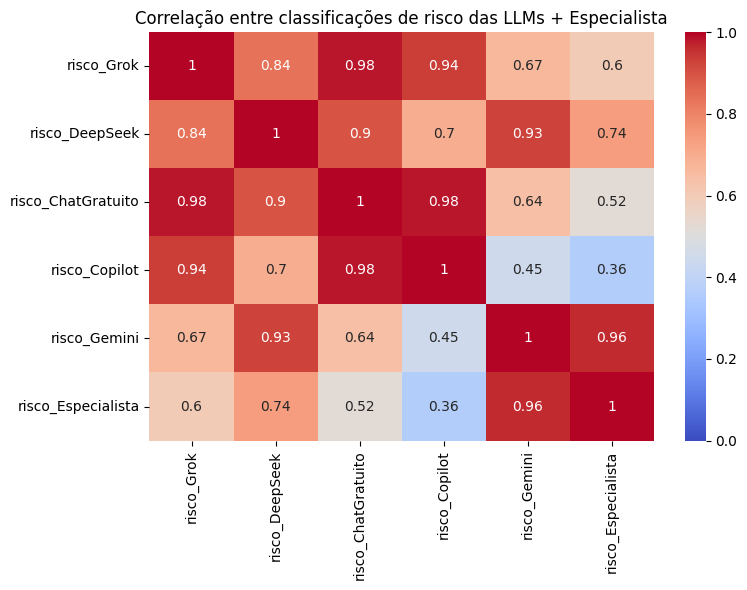

In [101]:
#HEATMAP

# 1. Carrega o arquivo consolidado
df = pd.read_csv('COMPILADO-classificacoes_multiplas.csv')

# 2. Converte os r√≥tulos de risco para n√∫meros
mapa_risco = {'Baixo': 0, 'Medio': 1, 'Alto': 2}

# Substitui applymap por apply + map (evita o FutureWarning)
df_num = df.drop(columns=['user']).apply(lambda col: col.map(mapa_risco))

# 3. Gera o heatmap de correla√ß√£o
plt.figure(figsize=(8, 6))
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Correla√ß√£o entre classifica√ß√µes de risco das LLMs + Especialista')
plt.tight_layout()
#plt.savefig("imagens/heatmap-llms", dpi=300)
plt.show()


/tmp/ipykernel_121667/4202969135.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_padronizado = df.drop(columns='user').applymap(lambda x: str(x).strip().capitalize())


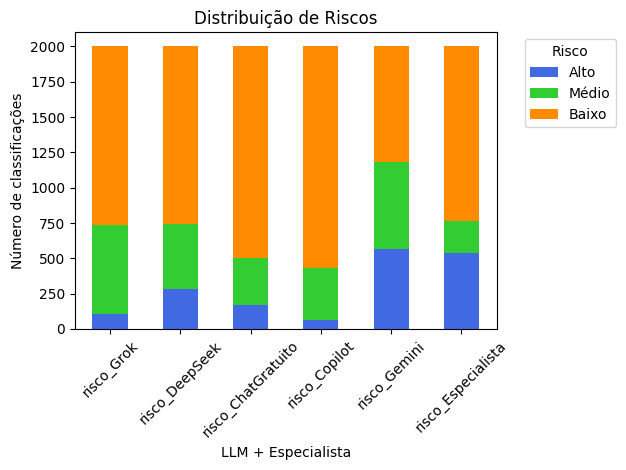

In [104]:
#GRAFICO BARRAS

# 1. Carrega o CSV
df = pd.read_csv('COMPILADO-classificacoes_multiplas.csv')

# 2. Padroniza os r√≥tulos de risco
df_padronizado = df.drop(columns='user').applymap(lambda x: str(x).strip().capitalize())

# 3. Calcula a contagem de r√≥tulos por LLM
df_freq = df_padronizado.apply(pd.Series.value_counts).T

# 4. Reordena as colunas na ordem desejada
ordem_riscos = ['Alto', 'M√©dio', 'Baixo']
df_freq = df_freq.reindex(columns=ordem_riscos, fill_value=0)

# 5. Define cores na mesma ordem
cores = ['royalblue', 'limegreen', 'darkorange']

# 6. Plota o gr√°fico
df_freq.plot(kind='bar', stacked=True, color=cores)

plt.title('Distribui√ß√£o de Riscos')
plt.ylabel('N√∫mero de classifica√ß√µes')
plt.xlabel('LLM + Especialista')
plt.legend(title='Risco', labels=ordem_riscos, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig("imagens/grafico-barra-comparativo2.png", dpi=300)
plt.show()


In [ ]:
# KUSKAL WALLIS

from scipy.stats import kruskal

# Carrega os riscos de cada LLM
#grok = pd.read_csv('datasets - llms/V2-GROK-dataset_com_risco.csv')['risco']
#chatgpt = pd.read_csv('datasets - llms/V2-CHATGPT-dataset_com_risco.csv')['risco']
#deepseek = pd.read_csv('datasets - llms/V2-DEEPSEEK-dataset_com_risco.csv')['risco']
#copilot = pd.read_csv('datasets - llms/V2-COPILOT-dataset_com_risco.csv')['risco']
gemini = pd.read_csv('datasets - llms/V2-GEMINI-dataset_com_risco.csv')['risco']
especialista = pd.read_csv('datasets - llms/V2-ESPECIALISTA-dataset_com_risco.csv')['risco']
#grok, chatgpt, deepseek, copilot, 

# Executa o teste de Kruskal-Wallis
stat, p = kruskal(gemini, radha)

# Interpreta√ß√£o
print(f'Estat√≠stica H = {stat:.4f}')
print(f'p-valor = {p:.4f}')
if p < 0.05:
    print("‚úÖ Diferen√ßa estat√≠stica significativa entre os grupos.")
else:
    print("‚ÑπÔ∏è N√£o h√° diferen√ßa estatisticamente significativa.")


Estat√≠stica H = 62.7342
p-valor = 0.0000
‚úÖ Diferen√ßa estat√≠stica significativa entre os grupos.


In [ ]:

from sklearn.metrics import cohen_kappa_score

# === 1. Carrega o CSV compilado ===
df = pd.read_csv("COMPILADO-classificacoes_multiplas.csv")

# === 2. Seleciona todas as colunas das LLMs (exceto risco_Especialista) ===
colunas_llm = [col for col in df.columns if col.startswith('risco_') and col != 'risco_Especialista']

# === 3. Calcula acur√°cia de concord√¢ncia ===
print("Acur√°cia de Concord√¢ncia e Kappa com risco_Especialista:\n")
for col in colunas_llm:
    total = len(df)
    acertos = (df[col] == df['risco_Especialista']).sum()
    acuracia = acertos / total
    kappa = cohen_kappa_score(df[col], df['risco_Especialista'])
    print(f"{col:<20} | Acur√°cia: {acuracia:.2%} | Kappa: {kappa:.3f}")



Acur√°cia de Concord√¢ncia e Kappa com risco_Especialista:

risco_Grok           | Acur√°cia: 69.65% | Kappa: 0.457
risco_DeepSeek       | Acur√°cia: 76.45% | Kappa: 0.570
risco_ChatGratuito   | Acur√°cia: 74.60% | Kappa: 0.487
risco_Copilot        | Acur√°cia: 73.15% | Kappa: 0.446
risco_Gemini         | Acur√°cia: 62.15% | Kappa: 0.405


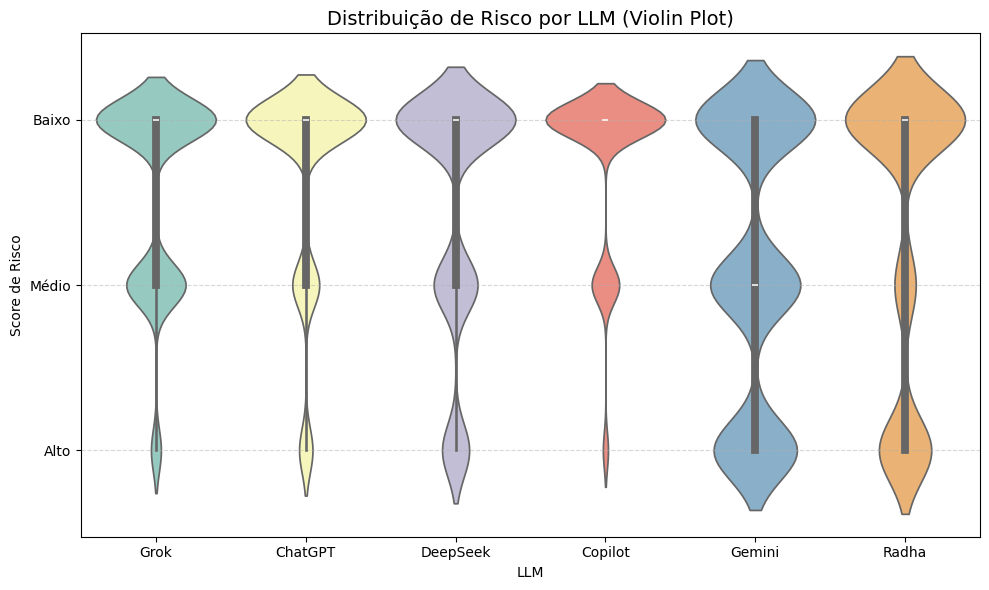

In [ ]:
#VIOLINO



# Lista de arquivos e nomes
arquivos = {
    'Grok': 'arquivos/V2-GROK-dataset_com_risco.csv',
    'ChatGPT': 'arquivos/V2-CHATGPT-dataset_com_risco.csv',
    'DeepSeek': 'arquivos/V2-DEEPSEEK-dataset_com_risco.csv',
    'Copilot': 'arquivos/V2-COPILOT-dataset_com_risco.csv',
    'Gemini': 'arquivos/V2-GEMINI-dataset_com_risco.csv',
    'Especialista' : 'arquivos/V2-ESPECIALISTA-dataset_com_risco.csv'
}

# Junta tudo em um √∫nico DataFrame
dados = []
for nome, arquivo in arquivos.items():
    df = pd.read_csv(arquivo)
    df_filtrado = df[['risco']].copy()
    df_filtrado['LLM'] = nome
    dados.append(df_filtrado)

df_riscos = pd.concat(dados, ignore_index=True)

# === Violin Plot corrigido ===
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_riscos,
    x='LLM',
    y='risco',
    hue='LLM',             # adiciona agrupamento por cor
    palette='Set3',
    inner='box',
    legend=False           # evita legenda repetida
)
plt.title('Distribui√ß√£o de Risco por LLM (Violin Plot)', fontsize=14)
plt.ylabel('Score de Risco')
plt.xlabel('LLM')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
print("Colunas dispon√≠veis em df_risco:", df_risco.columns.tolist())


Colunas dispon√≠veis em df_risco: ['Baixo', 'M√©dio', 'Alto']
